In [1]:
import torch
from torch import zeros
torch.set_default_dtype(torch.float64)
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style = 'white', color_codes = True)
%matplotlib inline

import sys
import os

import os
cwd = os.getcwd()

sys.path.append(cwd[:-len('befit/examples/temp_rev_learn')])

import pyro
pyro.enable_validation(True)

## Load behavioral data

In [2]:
df_res = pd.read_csv('pilot/responses.csv').set_index('subject')
responses = df_res.values[:, :-2].T.astype(float)

outcomes = pd.read_csv('pilot/outcomes.csv').set_index('subject').values.T.astype(float)
outcomes[np.nan_to_num(outcomes) < 2] = (outcomes[np.nan_to_num(outcomes) < 2] + 1)/2
outcomes[np.isnan(outcomes)] = 0.
corrects = pd.read_csv('pilot/correct_responses.csv').set_index('subject').values.T.astype(float)

states_and_rewards = io.loadmat('pilot/states_and_rewards.mat')
Sirr = states_and_rewards['irregular']['S'][0, 0][:, 0] - 1
Oirr = states_and_rewards['irregular']['R'][0, 0]
Sreg = states_and_rewards['regular']['S'][0, 0][:, 0] - 1
Oreg = states_and_rewards['regular']['R'][0, 0]

ns_reg = (df_res['condition'] == 'regular').sum()   # number of subjects in the regular reversals group
ns_irr = (df_res['condition'] == 'irregular').sum()  # number of subjects in the irregular reversals group

nsub = responses.shape[-1]

mask_all = torch.from_numpy(~np.isnan(responses)).unsqueeze(0)
responses_all = torch.from_numpy(np.nan_to_num(responses)).long().unsqueeze(0)
outcomes_all = torch.from_numpy(np.nan_to_num(outcomes)).long().unsqueeze(0)
offers_all = torch.zeros(responses_all.shape, dtype=torch.long)
corrects_all = torch.from_numpy(corrects).unsqueeze(0)

In [3]:
# split participants on groups and exclude non-explorers
expl_subs = torch.sum(torch.squeeze(responses_all == 2), 0) > -1
expl_sub_num = torch.arange(nsub)[expl_subs]
reg_subs = expl_sub_num[expl_sub_num < ns_reg]
irr_subs = expl_sub_num[expl_sub_num >= ns_reg]

mask_c1 = mask_all[..., reg_subs]
mask_c2 = mask_all[..., irr_subs]

responses_c1 = responses_all[..., reg_subs]
responses_c2 = responses_all[..., irr_subs]

offers_c1 = offers_all[..., reg_subs]
offers_c2 = offers_all[..., irr_subs]

outcomes_c1 = outcomes_all[..., reg_subs]
outcomes_c2 = outcomes_all[..., irr_subs]

corr_c1 = corrects_all[..., reg_subs]
corr_c2 = corrects_all[..., irr_subs]

In [4]:
from stats import trials_until_correct, running_mean, performance

data = io.loadmat('pilot/states_and_rewards.mat')
Sirr = data['irregular']['S'][0, 0][:, 0] - 1
Oirr = data['irregular']['R'][0, 0]
Sreg = data['regular']['S'][0, 0][:, 0] - 1
Oreg = data['regular']['R'][0, 0]
Sirr = torch.from_numpy(Sirr)
Oirr = torch.from_numpy(Oirr)
Sreg = torch.from_numpy(Sreg)
Oreg = torch.from_numpy(Oreg)

def plot_ppc(values, data, ax):
    perc = np.percentile(values, [5, 50, 95], axis=0)
    ax.errorbar(data, perc[1], yerr=np.diff(perc, axis=0), color='r', linestyle='', marker='o')
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--', lw=2)

def define_agents_and_environment(agent, pars, O, S, fixed_params=None):
    
    agents = []
    tasks = []
    
    for par, obs, states in zip(pars, O, S):
        T = len(states)
        vals = torch.from_numpy(par).reshape(-1, par.shape[-1])
        agents.append(agent(runs=vals.shape[0], trials=T))
        if fixed_params is not None:
            agents[-1].set_parameters()
            fixed = fixed_params['labels']
            free = list(set(range(agents[-1].npar)) - set(fixed))
            x = torch.zeros(vals.shape[:-1] + (agents[-1].npar,))
            x[..., free] = vals
        else:
            x = vals
        
        agents[-1].set_parameters(x)
        
        rewards = torch.cat([obs[None, :, :], states[None, :, None] + 2], -1)
        offers = zeros(1, T, 1, dtype=torch.long)
        
        runs = vals.shape[0]
        
        stimuli = {'states': states.reshape(1, T, 1), 
                   'rewards': rewards[..., None, :].repeat(1, 1, runs, 1), 
                   'offers': offers}
        
        tasks.append(TempRevLearn(stimuli=stimuli))

    return agents, tasks

tuc_data = trials_until_correct(np.nan_to_num(corr_c1[0].numpy()).T, Sreg[None].numpy(), τ=3)
rolling_tuc_data_c1 = running_mean(tuc_data, ws=201)
rolling_perf_data_c1 = performance(np.nan_to_num(corr_c1[0].numpy()), ws=201)

tuc_data = trials_until_correct(np.nan_to_num(corr_c2[0].numpy()).T, Sirr[None].numpy(), τ=3)
rolling_tuc_data_c2 = running_mean(tuc_data, ws=201)
rolling_perf_data_c2 = performance(np.nan_to_num(corr_c2[0].numpy()), ws=201)

## Fit behavioural models

In [5]:
from befit.agents import ImplicitNBHMM
from befit.inference import NormalGammaHierarch

from befit.tasks import TempRevLearn
from befit.simulate import Simulator

In [6]:
from pyro.infer.enum import get_importance_trace
import pyro

def get_log_marginal_likelhood(model, guide, repeat=10, num_samples=100):
    mpn = 2
    def vectorize(fn):
        def _fn(*args, **kwargs):
            with pyro.plate("num_particles_vectorized", num_samples, dim=-mpn):
                return fn(*args, **kwargs)
        return _fn
    
    log_prob = 0.
    for n in range(repeat):
        trace_model, trace_guide = get_importance_trace('flat', 
                                                        mpn, vectorize(model), 
                                                        vectorize(guide), 
                                                        (), 
                                                        {})

        for site in trace_model.nodes.values():
            if site['name'].startswith('obs'):
                log_prob += site['log_prob'].detach()
            if site['name'].startswith('locs'):
                log_prob += site['log_prob'].detach()

        for site in trace_guide.nodes.values():
            if site['name'].startswith('locs'):
                log_prob -= site['log_prob'].detach()
    
    return log_prob.mean(0)/repeat

In [ ]:
# perform sequential parameter estimate and model selection
trials = 250
iter_steps = 3000
num_particles = 100
num_samples = 100

vals = zeros(responses_all.shape[-1], 1)
fixed_params = {
    'labels': [5],
    'values': vals
}

T1 = 550
T2 = T1 + trials

post_nbhmm = []
mll_nbhmm = []

for order in range(1, 11):
    nbhmm_agent = ImplicitNBHMM(order, runs=responses_all.shape[-1], trials=trials)
    nbhmm_agent.set_parameters()
    
    mask = mask_all[:, T1:T2].clone()
    offers = offers_all[:, T1:T2].clone()
    outcomes = outcomes_all[:, T1:T2].clone()
    responses = responses_all[:, T1:T2].clone()
    stimuli = {'offers': offers, 
               'outcomes': outcomes,
               'mask': mask.double()}
    
    mask[:, :50] = 0
    
    nbhmm_infer = NormalGammaHierarch(nbhmm_agent, stimuli, responses, mask=mask, fixed_params=fixed_params)
    nbhmm_infer.infer_posterior(iter_steps=iter_steps, num_particles=num_particles)
    
    mll_nbhmm.append(get_log_marginal_likelhood(nbhmm_infer.model, nbhmm_infer.guide))
    
    labels = ['mu', 'beta', 'lam', 'ph', 'pl', 'omega']
    post_nbhmm.append(nbhmm_infer.sample_posterior(labels, num_samples=num_samples))

In [34]:
for order in range(10, 11):
    nbhmm_agent = ImplicitNBHMM(order, runs=responses_all.shape[-1], trials=trials)
    nbhmm_agent.set_parameters()
    
    mask = mask_all[:, T1:T2].clone()
    offers = offers_all[:, T1:T2].clone()
    outcomes = outcomes_all[:, T1:T2].clone()
    responses = responses_all[:, T1:T2].clone()
    stimuli = {'offers': offers, 
               'outcomes': outcomes,
               'mask': mask.double()}
    
    mask[:, :50] = 0
    
    nbhmm_infer = NormalGammaHierarch(nbhmm_agent, stimuli, responses, mask=mask, fixed_params=fixed_params)
    nbhmm_infer.infer_posterior(iter_steps=iter_steps, num_particles=num_particles)
    
    mll_nbhmm.append(get_log_marginal_likelhood(nbhmm_infer.model, nbhmm_infer.guide))
    
    labels = ['mu', 'beta', 'lam', 'ph', 'pl', 'omega']
    post_nbhmm.append(nbhmm_infer.sample_posterior(labels, num_samples=num_samples))

Mean ELBO 32033.61:   0%|          | 1/3000 [00:05<4:26:57,  5.34s/it]


ValueError: The parameter logits has invalid values
                Trace Shapes:            
                 Param Sites:            
                            a         6  
                          lam         6  
                            m         6  
                            s         6  
                Sample Sites:            
num_particles_vectorized dist         |  
                        value     100 |  
                     tau dist 100   1 | 6
                        value 100   1 | 6
                      mu dist 100   1 | 6
                        value 100   1 | 6
                    runs dist         |  
                        value      50 |  
                    locs dist 100  50 | 6
                        value 100  50 | 6
                 obs_0_0 dist 100  50 |  
                        value      50 |  
                 obs_0_1 dist 100  50 |  
                        value      50 |  
                 obs_0_2 dist 100  50 |  
                        value      50 |  
                 obs_0_3 dist 100  50 |  
                        value      50 |  
                 obs_0_4 dist 100  50 |  
                        value      50 |  
                 obs_0_5 dist 100  50 |  
                        value      50 |  
                 obs_0_6 dist 100  50 |  
                        value      50 |  
                 obs_0_7 dist 100  50 |  
                        value      50 |  
                 obs_0_8 dist 100  50 |  
                        value      50 |  
                 obs_0_9 dist 100  50 |  
                        value      50 |  
                obs_0_10 dist 100  50 |  
                        value      50 |  
                obs_0_11 dist 100  50 |  
                        value      50 |  
                obs_0_12 dist 100  50 |  
                        value      50 |  
                obs_0_13 dist 100  50 |  
                        value      50 |  
                obs_0_14 dist 100  50 |  
                        value      50 |  
                obs_0_15 dist 100  50 |  
                        value      50 |  
                obs_0_16 dist 100  50 |  
                        value      50 |  
                obs_0_17 dist 100  50 |  
                        value      50 |  
                obs_0_18 dist 100  50 |  
                        value      50 |  
                obs_0_19 dist 100  50 |  
                        value      50 |  
                obs_0_20 dist 100  50 |  
                        value      50 |  
                obs_0_21 dist 100  50 |  
                        value      50 |  
                obs_0_22 dist 100  50 |  
                        value      50 |  
                obs_0_23 dist 100  50 |  
                        value      50 |  
                obs_0_24 dist 100  50 |  
                        value      50 |  
                obs_0_25 dist 100  50 |  
                        value      50 |  
                obs_0_26 dist 100  50 |  
                        value      50 |  
                obs_0_27 dist 100  50 |  
                        value      50 |  
                obs_0_28 dist 100  50 |  
                        value      50 |  
                obs_0_29 dist 100  50 |  
                        value      50 |  
                obs_0_30 dist 100  50 |  
                        value      50 |  
                obs_0_31 dist 100  50 |  
                        value      50 |  
                obs_0_32 dist 100  50 |  
                        value      50 |  
                obs_0_33 dist 100  50 |  
                        value      50 |  
                obs_0_34 dist 100  50 |  
                        value      50 |  
                obs_0_35 dist 100  50 |  
                        value      50 |  
                obs_0_36 dist 100  50 |  
                        value      50 |  
                obs_0_37 dist 100  50 |  
                        value      50 |  
                obs_0_38 dist 100  50 |  
                        value      50 |  
                obs_0_39 dist 100  50 |  
                        value      50 |  
                obs_0_40 dist 100  50 |  
                        value      50 |  
                obs_0_41 dist 100  50 |  
                        value      50 |  
                obs_0_42 dist 100  50 |  
                        value      50 |  
                obs_0_43 dist 100  50 |  
                        value      50 |  
                obs_0_44 dist 100  50 |  
                        value      50 |  
                obs_0_45 dist 100  50 |  
                        value      50 |  
                obs_0_46 dist 100  50 |  
                        value      50 |  
                obs_0_47 dist 100  50 |  
                        value      50 |  
                obs_0_48 dist 100  50 |  
                        value      50 |  
                obs_0_49 dist 100  50 |  
                        value      50 |  
                obs_0_50 dist 100  50 |  
                        value      50 |  
                obs_0_51 dist 100  50 |  
                        value      50 |  
                obs_0_52 dist 100  50 |  
                        value      50 |  
                obs_0_53 dist 100  50 |  
                        value      50 |  
                obs_0_54 dist 100  50 |  
                        value      50 |  
                obs_0_55 dist 100  50 |  
                        value      50 |  
                obs_0_56 dist 100  50 |  
                        value      50 |  
                obs_0_57 dist 100  50 |  
                        value      50 |  
                obs_0_58 dist 100  50 |  
                        value      50 |  
                obs_0_59 dist 100  50 |  
                        value      50 |  
                obs_0_60 dist 100  50 |  
                        value      50 |  
                obs_0_61 dist 100  50 |  
                        value      50 |  
                obs_0_62 dist 100  50 |  
                        value      50 |  
                obs_0_63 dist 100  50 |  
                        value      50 |  
                obs_0_64 dist 100  50 |  
                        value      50 |  
                obs_0_65 dist 100  50 |  
                        value      50 |  
                obs_0_66 dist 100  50 |  
                        value      50 |  
                obs_0_67 dist 100  50 |  
                        value      50 |  
                obs_0_68 dist 100  50 |  
                        value      50 |  
                obs_0_69 dist 100  50 |  
                        value      50 |  

In [33]:
post_samples = pd.DataFrame()
for n, ps in enumerate(post_nbhmm):
    ps[0]['n'] = n + 1
    post_samples = post_samples.append(ps[0], ignore_index=True)
np.savez('posterior_probs_models_T_600_800.npz', 
         mll=torch.stack(mll_nbhmm).numpy(), 
         samples=post_samples.values, 
         columns=list(post_samples.columns))

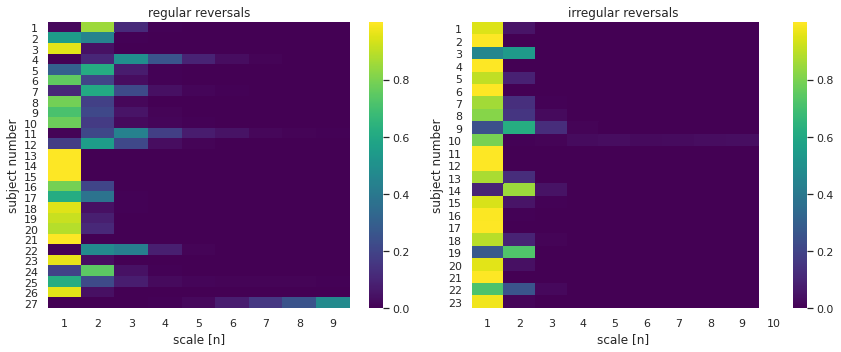

In [14]:
mll = torch.stack(mll_nbhmm, -1)
post = mll.softmax(-1)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
sns.heatmap(post[:ns_reg], xticklabels=range(1, 11), yticklabels=range(1, ns_reg+1), ax=axes[0], cmap='viridis')
sns.heatmap(post[ns_reg:], xticklabels=range(1, 11), yticklabels=range(1, ns_irr+1), ax=axes[1], cmap='viridis')

axes[0].set_xlabel('scale [n]');
axes[0].set_ylabel('subject number');
axes[0].set_title('regular reversals');
axes[1].set_xlabel('scale [n]');
axes[1].set_ylabel('subject number');
axes[1].set_title('irregular reversals');

fig.tight_layout()
fig.savefig('model_selection.svg', transparent=True)

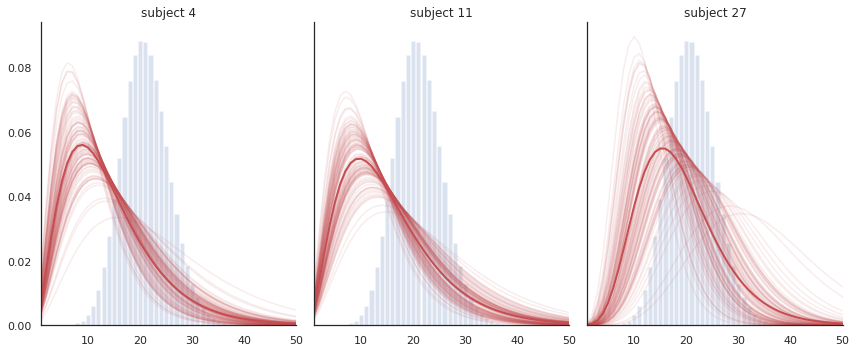

In [86]:
from scipy.special import binom
subs = [4, 11, 27] 
scale = [2, 2, 9]

fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey='row')

d = np.arange(1, 101)
p = 20/(20 + 1000)
true_pd = binom(d + 1000 - 2, d - 1) * (1 - p)**(1000) * p **(d - 1)

for sub, scl, i in zip(subs, scale, range(3)):
    df = post_nbhmm[scl][1]
    mu = df['mu'].values.reshape(-1, 50)[..., sub-1]
    p = np.expand_dims(mu/(mu + scl + 1), -1)
    
    pd = binom(d + scl - 1, d - 1) * (1 - p)**(scl + 1) * p **(d - 1)
    axes[i].plot(d, pd.T, 'r', alpha=.1)
    axes[i].plot(d, pd.mean(0), 'r', lw=2)

    axes[i].set_xlim([d[0], 50])
    axes[i].bar(d, height=true_pd, alpha=.2)
    
    axes[i].set_title('subject {}'.format(sub))

fig.tight_layout()
sns.despine(fig)
fig.savefig('dur_dist.svg', transparent=True)